[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)



# 时间旅行（Time travel）

## 评论（Review）

We discussed motivations for human-in-the-loop:

我们讨论了人类参与循环的动力：

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

`Approval` - 我们可以中断代理，将状态呈现给用户，并允许用户接受一个操作

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(2) `Debugging` - 我们可以回退图形以重现或避免问题

(3) `Editing` - You can modify the state 

(3) `Editing` - 您可以修改状态

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

我们展示了如何使用断点来在特定节点停止图，或者让图动态中断自身。

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

然后我们展示了如何在有人类批准的情况下继续，或者直接根据人类反馈编辑图状态。

## 目标（Goals）

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

现在，让我们通过查看、重播，甚至从过去的状态叉出，来展示 LangGraph [支持debug](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) 的功能。

We call this `time travel`.

我们称此为 `time travel`。



In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Let's build our agent.

让我们构建我们的代理。



In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(
    model="qwen-plus-2025-04-28",
    api_key="sk-ba2dda3817f145d7af141fdf32e31d90",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"
)
llm_with_tools = llm.bind_tools(tools)

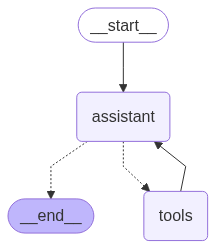

In [4]:
from IPython.display import Image, display


from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode


from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# 系统消息
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


# 节点
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


# 图
builder = StateGraph(MessagesState)


# 定义节点：这些节点负责执行工作
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))


# 定义边：这些边决定了控制流程
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # 如果助手的最新消息（结果）是工具调用 -> tools_condition 路由到 tools
    # 如果助手的最新消息（结果）不是工具调用 -> tools_condition 路由到 END
    tools_condition,
)
builder.add_edge("tools", "assistant")


memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())


# 显示
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.


In [5]:
# Input
initial_input = {"messages": HumanMessage(content="2乘3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

2乘3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0f93086f9fb640069a833c)
 Call ID: call_0f93086f9fb640069a833c
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2乘3的结果是6。


## 浏览历史（Browsing History）

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

我们可以使用 `get_state` 来查看给定 `thread_id` 的图的 **当前** 状态！



In [6]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0f93086f9fb640069a833c', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 350, 'total_tokens': 374, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-04-28', 'system_fingerprint': None, 'id': 'chatcmpl-369e84c7-b423-906d-bd8a-dfa89ba6fe4c', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--95dfd22c-8cb0-4f9e-a8aa-cf017c5121ea-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0f93086f9fb640069a833c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 350, 'output_tokens': 24, 'total_tokens': 374, 'input_token_details': {}

We can also browse the state history of our agent.

我们还可以浏览代理的状态历史。

`get_state_history` lets us get the state at all prior steps.


`get_state_history` 让我们能够获取所有先前步骤的状态。



In [7]:
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

In [9]:
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0f93086f9fb640069a833c', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 350, 'total_tokens': 374, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-04-28', 'system_fingerprint': None, 'id': 'chatcmpl-369e84c7-b423-906d-bd8a-dfa89ba6fe4c', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--95dfd22c-8cb0-4f9e-a8aa-cf017c5121ea-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_0f93086f9fb640069a833c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 350, 'output_tokens': 24, 'total_tokens': 374, 'input_token_details': {

The first element is the current state, just as we got from `get_state`.

第一个元素是当前状态，就像我们从 `get_state` 获取的一样。



In [10]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-904c-66f8-8000-232e1481b21e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-07-22T06:14:17.288462+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-904a-6123-bfff-eb657df4d8e6'}}, tasks=(PregelTask(id='93ea88ed-d95c-4fc2-62d1-1fd82dbc55b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0f93086f9fb640069a833c', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 350, 

Everything above we can visualize here: 

我们可以在上方看到所有内容的可视化：

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)



## 回放（Replaying）

We can re-run our agent from any of the prior steps.

我们可以从之前的任何步骤重新运行代理。

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)



Let's look back at the step that recieved human input!

让我们回顾一下接收人类输入的步骤！



In [11]:
to_replay = all_states[-2]

In [12]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-904c-66f8-8000-232e1481b21e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-07-22T06:14:17.288462+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-904a-6123-bfff-eb657df4d8e6'}}, tasks=(PregelTask(id='93ea88ed-d95c-4fc2-62d1-1fd82dbc55b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0f93086f9fb640069a833c', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 350, 

Look at the state.

看看状态。



In [13]:
to_replay.values

{'messages': [HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]}

We can see the next node to call.


In [14]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

我们还获取了配置，它告诉了我们 `checkpoint_id` 以及 `thread_id`。



In [15]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f066c31-904c-66f8-8000-232e1481b21e'}}

To replay from here, we simply pass the config back to the agent!

要从这里重播，我们只需将配置传回给代理！

The graph knows that this checkpoint has aleady been executed. 

图知道这个检查点已经执行过了。

It just re-plays from this checkpoint!

它只是从这个检查点重新播放！



In [16]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

2乘3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_de278ff6e3fd4b3f8b50d6)
 Call ID: call_de278ff6e3fd4b3f8b50d6
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2乘3的结果是6。


Now, we can see our current state after the agent re-ran.

现在，我们可以看到代理重新运行后的当前状态。



## Forking
What if we want to run from that same step, but with a different input.

如果我们想从相同的步骤运行，但使用不同的输入，该怎么办呢？

This is forking.

这是分叉。

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)



In [17]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='2乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]

Again, we have the config.

再次，我们有配置。



In [18]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f066c31-904c-66f8-8000-232e1481b21e'}}

Let's modify the state at this checkpoint.

让我们修改此检查点的状态。

We can just run `update_state` with the `checkpoint_id` supplied. 

我们可以直接使用提供的 `checkpoint_id` 来运行 `update_state`。

Remember how our reducer on `messages` works: 
* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

*它会追加，除非我们提供消息 ID。* 我们提供消息 ID 以覆盖消息，而不是追加到状态！

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

因此，要覆盖消息，我们只需提供消息 ID，而我们已有 `to_fork.values["messages"].id`。



In [19]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='5乘3', 
                               id=to_fork.values["messages"][0].id)]},
)

In [20]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f066c31-b882-68de-8001-6cfd75621c9d'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

这创建了一个新的、分叉的检查点。

但是，元数据——例如，下一步去哪里——被保留了！

We can see the current state of our agent has been updated with our fork.

我们可以看到，我们的代理当前状态已通过我们的分支进行了更新。



In [21]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='5乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]

In [22]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='5乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-b882-68de-8001-6cfd75621c9d'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-07-22T06:14:21.504932+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f066c31-904c-66f8-8000-232e1481b21e'}}, tasks=(PregelTask(id='9ac61ce9-0641-2db1-09bb-e057db79efad', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, when we stream, the graph knows this checkpoint has never been executed.

现在，当我们进行流式传输时，图知道这个检查点从未被执行过。

So, the graph runs, rather than simply re-playing.

因此，图形运行，而不是简单地重播。



In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

5乘3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2d1523fe7a424592a6fc23)
 Call ID: call_2d1523fe7a424592a6fc23
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

5乘3的结果是15。


Now, we can see the current state is the end of our agent run.

现在，我们可以看到当前状态是我们的代理运行的结束。



In [24]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='5乘3', additional_kwargs={}, response_metadata={}, id='682f56f7-13fa-4ee3-a4ad-a245e9f770de'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2d1523fe7a424592a6fc23', 'function': {'arguments': '{"a": 5, "b": 3}', 'name': 'multiply'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 350, 'total_tokens': 374, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-2025-04-28', 'system_fingerprint': None, 'id': 'chatcmpl-40869b4b-a56a-9c18-8b62-b411f1fea0b2', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b60295ed-44d9-4727-a34a-d98195e1df8d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_2d1523fe7a424592a6fc23', 'type': 'tool_call'}], usage_metadata={'input_tokens': 350, 'output_tokens': 24, 'total_tokens': 374, 'input_token_details': {}

### 通过 LangGraph API 进行时间旅行（Time travel with LangGraph API）

**⚠️ DISCLAIMER**

**⚠️ 警告免责声明**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

自从这些视频的拍摄以来，我们已经更新了 Studio，使其可以本地运行并在浏览器中打开。这是现在运行 Studio 的首选方式（而不是像视频中展示的那样使用桌面应用程序）。请参阅关于本地开发服务器的文档 [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) 和 [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)。要启动本地开发服务器，请在本模块的 `/studio` 目录中，在终端运行以下命令：

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

你应该看到以下输出：  
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

打开您的浏览器并导航到 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

我们通过 SDK 连接到它，并展示如何使用 LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation)。



In [25]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [26]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### 重播（Re-playing）

Let's run our agent streaming `updates` to the state of the graph after each node is called.

让我们在每个节点被调用后，将代理流式传输的状态 `updates` 记录到图的状态中。



In [27]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

ConnectError: All connection attempts failed

Now, let's look at **replaying** from a specified checkpoint. 

现在，让我们来看一下从指定检查点 **回放**。

We simply need to pass the `checkpoint_id`.

我们只需要传递 `checkpoint_id`.



In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e497456f-827a-5027-87bd-b0ccd54aa89a',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a449-7fbc-6c90-8754-4e6b1b582790',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '708e1d8f-f7c8-4093-9bb4-999c4237cb4a',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:33:51.380352+00:00',
 'checkpoint_id': '1ef6a449-817f-6b55-8000-07c18fbdf7c8',
 'parent_checkpoint_id': '1ef6a449-816c-6fd6-bfff-32a56dd2635f'}

Let's stream with `stream_mode="values"` to see the full state at every node as we replay. 

让我们在重播时使用 `stream_mode="values"` 来查看每个节点的完整状态。



In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a44a-5806-6bb1-b2ee-92ecfda7f67d'}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_Rn9YQ6iZyYtzrELBz7EfQcs0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_1

We can all view this as streaming only `updates` to state made by the nodes that we reply.

我们可以都将此视为仅 `updates` 流式传输到我们回复的节点所生成的状态。



In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-550e75ad-dbbc-4e55-9f00-aa896228914c', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '731b7d4f-780d-4a8b-aec9-0d8b9c58c40a', 'tool_call_id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

#### 叉子（Forking）

Now, let's look at forking.

现在，让我们看看分叉。

Let's get the same step as we worked with above, the human input.

让我们获取与上面处理过的相同的步骤，即人类输入。

Let's create a new thread with our agent.

让我们用我们的代理创建一个新线程。



In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-cbd081b1-8cef-4ca8-9dd5-aceb134404dc', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '11dd4a7f-0b6b-44da-b9a4-65f1677c8813', 'tool_call_id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
   'example': False}]}

In [ ]:
to_fork['values']['messages'][0]['id']

'93c18b95-9050-4a52-99b8-9374e98ee5db'

In [ ]:
to_fork['next']

['assistant']

In [ ]:
to_fork['checkpoint_id']

'1ef6a44b-27ec-681c-8000-ff7e345aee7e'

Let's edit the state.

让我们编辑状态。

Remember how our reducer on `messages` works: 

记住我们的 `messages` 减少器是如何工作的：

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!


In [ ]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [ ]:
forked_config

{'configurable': {'thread_id': 'c99502e7-b0d7-473e-8295-1ad60e2b7ed2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'},
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'}

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'da5d6548-62ca-5e69-ba70-f6179b2743bd',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'parents': {},
  'graph_id': 'agent'},
 'created_at': '2024-09-03T22:34:46.678333+00:00',
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34',
 'parent_checkpoint_id': '1ef6a44b-27ec-681c-8000-ff7e345aee7e'}

To rerun, we pass in the `checkpoint_id`.

要重新运行，我们传入 `checkpoint_id`.



In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-e9759422-e537-4b9b-b583-36c688e13b4b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '89787b0b-93de-4c0a-bea8-d2c3845534e1', 'tool_call_id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.

让我们在 Studio UI 中查看使用了 `agent` 的分支操作，它使用了在 `module-1/studio/langgraph.json` 中设置的 `module-1/studio/agent.py`。

